<a href="https://colab.research.google.com/github/shamim237/Cavity_U-net/blob/main/cavity_prediction(full_%26_final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Notebook, I have resized the original images and masks to the shape of 256x256. Then trained the dataset using the U-net Model.
For prediction, I have resized the Original test images, masks and predicted masks to the shape of 512x748 and this way i got better result.

# Load Required Libraries

In [ ]:
"import required libraries"

import tensorflow as tf
import os
import random
import numpy as np
import cv2 
from tqdm import tqdm 
import glob
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
seed = 42
np.random.seed = seed

# Load pre-Saved Numpy file of training and test dataset

In [ ]:
X_train = np.load('/content/drive/MyDrive/Cavity Project/Numpy_array files/X_train(256).npy')
y_train = np.load('/content/drive/MyDrive/Cavity Project/Numpy_array files/y_train(256).npy')

In [ ]:
X_test = np.load('/content/drive/MyDrive/Cavity Project/Numpy_array files/X_test(last).npy')
y_test = np.load('/content/drive/MyDrive/Cavity Project/Numpy_array files/y_test(last).npy')

In [ ]:
X_train.shape

(8620, 256, 256, 3)

In [ ]:
X_test.shape, y_test.shape

((45, 256, 256, 3), (45, 256, 256, 1))

### **Plot the training images with its corresponding masks**

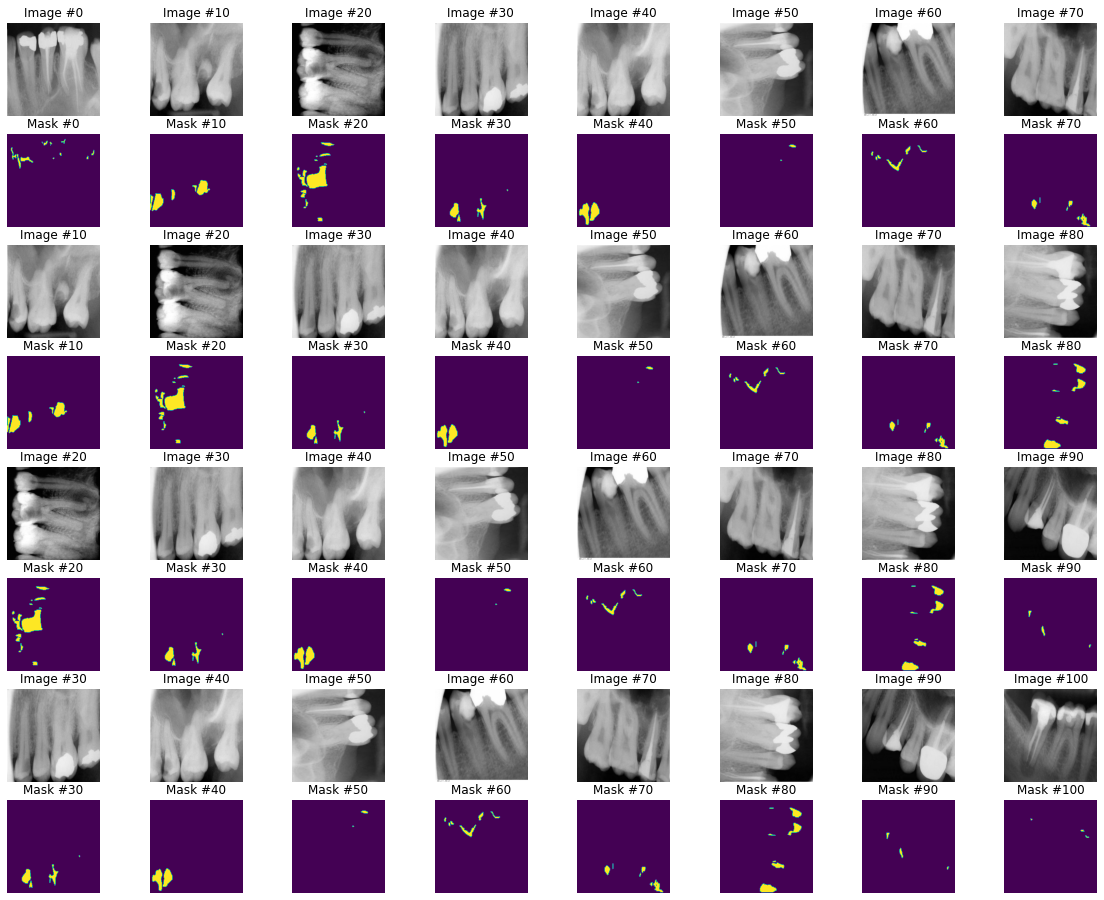

In [ ]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 8,4
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*10 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Plot the test images with its corresponding test masks


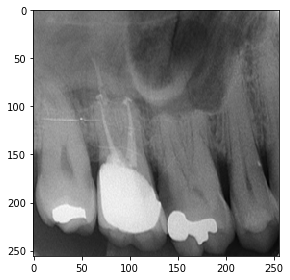

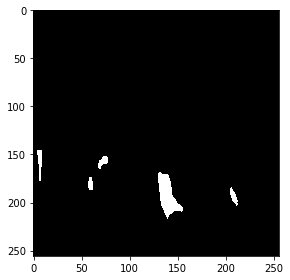

In [ ]:
imshow(X_test[33])
plt.show()
imshow(np.squeeze(y_test[33]), cmap = 'gray')
plt.show()

# Build the U-Net Model

In [ ]:

#Build the model
inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#model.summary()

# Define Dice and IOU coefficient

In [ ]:
from keras import backend as K
def dice_coef(y_test, y_pred, smooth = 0.0001):
  y_true_f = K.flatten(y_test)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2 * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou_coef(y_test, y_pred, smooth = 0.0001):
  y_true_f = K.flatten(y_test)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
  return intersection/(union + smooth)

# Add checkpoints and compile the model for training

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Cavity Project/Model/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
# model.compile(optimizer= tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=[dice_coef, iou_coef, 'acc'])

In [ ]:
#history = model.fit(X_train, y_train, validation_split= 0.25, callbacks= [checkpoint], batch_size= 24, epochs= 250)

# Load the weights of pre-trained U-Net model

In [ ]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Cavity Project/Model/Best model/model-239-0.998081-0.998468.h5',
                                custom_objects={"dice_coef": dice_coef, "iou_coef": iou_coef})

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

2/2 [==============================] - 1s 1s/step


In [ ]:
#UPSAMPLE THE PREDICTED MASKS (748X512)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (748, 512), 
                                       mode='constant', preserve_range=True))

In [ ]:
us = np.expand_dims(preds_test_upsampled, axis = -1)
us

array([[[[6.37328867e-06],
         [9.86440409e-06],
         [1.25977749e-05],
         ...,
         [7.31450837e-06],
         [3.77759875e-06],
         [1.50685787e-06]],

        [[9.39219899e-06],
         [1.45274298e-05],
         [1.85364242e-05],
         ...,
         [1.07646583e-05],
         [5.57489147e-06],
         [2.23500615e-06]],

        [[6.72329361e-06],
         [1.01517726e-05],
         [1.25265351e-05],
         ...,
         [7.32786020e-06],
         [4.19554772e-06],
         [1.97204372e-06]],

        ...,

        [[1.11365780e-05],
         [1.27258681e-05],
         [8.48006312e-06],
         ...,
         [4.86313111e-05],
         [3.02905810e-05],
         [1.58401617e-05]],

        [[1.58471321e-05],
         [1.82739586e-05],
         [1.25628558e-05],
         ...,
         [7.42007251e-05],
         [4.62213538e-05],
         [2.41737525e-05]],

        [[1.07586711e-05],
         [1.24092967e-05],
         [8.53809979e-06],
         ...,
 

In [ ]:
# preds_test_thresh = (us >= 0.5).astype(np.uint8)
# test_img = preds_test_thresh[6, :, :, 0]
# plt.imshow(test_img, cmap='gray')

# Check the prediction

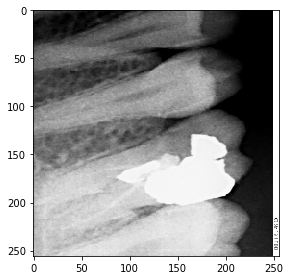

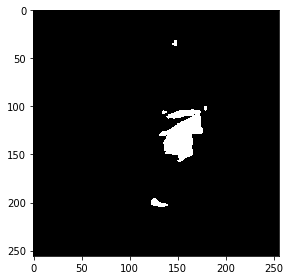

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


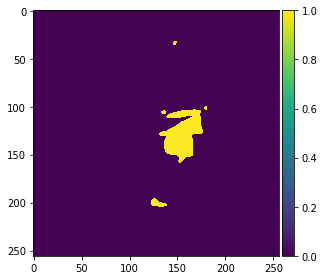

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()


from skimage.io import imread, imshow, imread_collection, concatenate_images
ymg = preds_train_t[ix][:,:,0]
imshow(ymg)
plt.show()

## Predict the test dataset

In [ ]:
y_pred = model.predict(X_test)

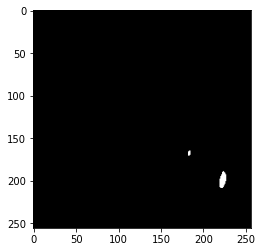

In [ ]:
preds_test_thresh = (y_pred >= 0.5).astype(np.uint8)
test_img = preds_test_thresh[6, :, :, 0]
plt.imshow(test_img, cmap='gray')

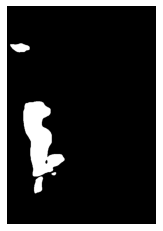

In [ ]:
# #SAVE PREDICTED MASK IMAGES(as original shape)

# for i in range(len(X_test)):
#   preds_test_thresh = (us >= 0.5).astype(np.uint8)
#   test_img = preds_test_thresh[i, :, :, 0]
#   plt.imshow(test_img, cmap ='gray')
#   plt.axis('off')
#   plt.imsave("/content/drive/MyDrive/Cavity Project/Dataset/Pred_mask(org_shape)/%d.png"%(i+1), test_img,format = 'png', cmap = 'gray')

In [ ]:
print(len(X_test))

45


# Calculate the Performace of prediction using Dice and IOU score

In [ ]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    #union1 = 0.00001 + union
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [ ]:
y_test.shape, preds_test_thresh.shape

((45, 256, 256, 1), (45, 256, 256, 1))


### Calculate the average IOU score

In [ ]:
iou=[]
for i in range(len(y_test)):
    iou.append(cal_iou(np.squeeze(y_test[i]), np.squeeze(preds_test_thresh[i])))
print('Average IOU: {}'.format(round(np.mean(iou),2)))

Average IOU: 0.93


## Plot the individual IOU score for test images with predicted masks

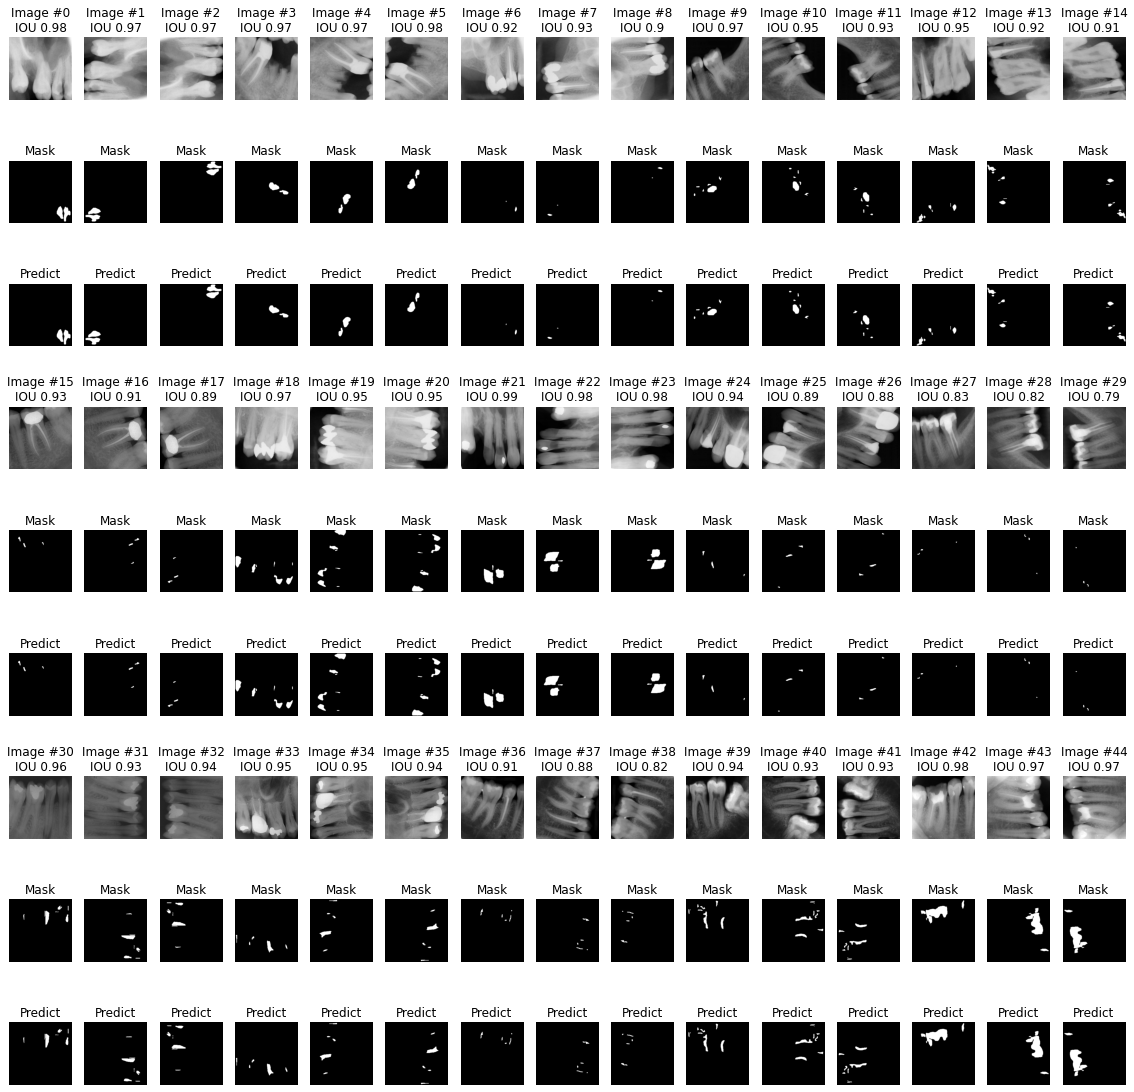

In [ ]:
"plot the individual IOU Score with predicted and true masks"

plt.figure(figsize=(20,20))
x, y = 15, 3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_test[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(y_test[pos]), np.squeeze(preds_test_thresh[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(y_test[pos]), cmap = 'gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_test_thresh[pos]), cmap = 'gray')
        plt.title('Predict')
        plt.axis('off')
plt.show()

### Calculate the average Dice Score

In [ ]:
def dice_score(A, B):
    intersection = np.logical_and(A, B)
    mask_sum = np.sum(A) + np.sum(B)
    #mask_sum1 = 0.00001 + mask_sum
    dice = np.sum(2 * (intersection)/(mask_sum))
    return dice

In [ ]:
dice= []
for i in range(len(y_test)):
    dice.append(dice_score(np.squeeze(y_test[i]), np.squeeze(preds_test_thresh[i])))
print('Average Dice score: {}'.format(round(np.mean(dice),2)))

Average Dice score: 0.96


### Plot the individual Dice score with its predicted masks



In [ ]:
"plot the individual DICE Score with predicted and true masks"



plt.figure(figsize=(20,22))
x, y = 15,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_test[pos])
        plt.title('Image #{}\nDice {}'.format(pos,round(dice_score(np.squeeze(y_test[pos]), np.squeeze(preds_test_thresh[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(y_test[pos]), cmap = 'gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_test_thresh[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

### Save the Predicted masks (256x256)


In [ ]:
# #SAVE PREDICTED MASK IMAGES

# for i in range(len(X_test)):
#   preds_test_thresh = (y_pred >= 0.5).astype(np.uint8)
#   test_img = preds_test_thresh[i, :, :, 0]
#   plt.imshow(test_img, cmap ='gray')
#   plt.axis('off')
#   plt.imsave("/content/drive/MyDrive/Colab Notebooks/last_pred/%d.png"%(i+1), test_img,format = 'png', cmap = 'gray')

# Calculate the Dice and IOU score of predicted masks with original size of image and masks

In [ ]:
# !unzip '/content/drive/MyDrive/Cavity Project/Zip Files/test_data(original_shape).zip' -d '/content/drive/MyDrive'

### Load the Original images of shape 748x512

In [ ]:
# img_dir = '/content/drive/MyDrive/Cavity Project/Dataset/test_data(org_shape)/'
# test_org_img = []
# test_img = os.listdir(img_dir + 't_img/')
# for i, image_name in enumerate(test_img):
#   if (image_name.split('.') [1] == 'png'):
#     image = cv2.imread(img_dir + 't_img/' + image_name)
#     image = Image.fromarray(image, 'RGB') 
#     #image = image.resize((512, 748))
#     test_org_img.append(np.array(image))
#     #label.append(0)
#     print(image_name)

In [ ]:
# X_test_org = np.array(test_org_img, dtype= np.uint8)
# X_test_org.shape

(30, 748, 512, 3)

### Load the Original Mask images with shape of 748x512

In [ ]:
# test_org_mask = []

# test_mask = os.listdir(img_dir + '/t_mask/')
# for i, image_name in enumerate(test_mask):
#   if (image_name.split('.') [1] == 'png'):
#     image = cv2.imread(img_dir + '/t_mask/' + image_name, 0)
#     image = Image.fromarray(image) 
#     #image = image.resize((512, 748))
#     test_org_mask.append(np.array(image, dtype= np.bool))
#     #label.append(0)
#     print(image_name)

In [ ]:
# y_test_org = np.array(test_org_mask, dtype= np.bool)
# y_test_org = np.expand_dims(y_test_org, axis = -1)
# y_test_org.shape

(30, 748, 512, 1)

### Load the pre-saved Preicted masks and resized to shape of 748x512

In [ ]:
# pred_org_mask = []

# pred_mask = os.listdir(img_dir + '/t_pred/')
# for i, image_name in enumerate(pred_mask):
#   if (image_name.split('.') [1] == 'png'):
#     image = cv2.imread(img_dir + '/t_pred/' + image_name, 0)
#     image = Image.fromarray(image) 
#     #image = image.resize((512, 748))
#     pred_org_mask.append(np.array(image, dtype= np.bool))
#     #label.append(0)
#     print(image_name)

In [ ]:
# y_pred_org = np.array(pred_org_mask, dtype= np.bool)
# y_pred_org = np.expand_dims(y_pred_org, axis = -1)
# y_pred_org.shape

(30, 748, 512, 1)

### Save and Load the Numpy files of Original test images and masks along with predicted masks(OLD)




In [ ]:
# np.save('/content/drive/MyDrive/Cavity Project/Numpy_array files/X_test_org(upsampled).npy', X_test_org)
# np.save('/content/drive/MyDrive/Cavity Project/Numpy_array files/y_test_org(upsampled).npy', y_test_org)
# np.save('/content/drive/MyDrive/Cavity Project/Numpy_array files/y_pred_org(upsampled).npy', y_pred_org)

In [ ]:
X_test_org = np.load('/content/drive/MyDrive/Cavity Project/Numpy_array files/X_test_org(upsampled).npy')
y_test_org = np.load('/content/drive/MyDrive/Cavity Project/Numpy_array files/y_test_org(upsampled).npy')
y_pred_org = np.load('/content/drive/MyDrive/Cavity Project/Numpy_array files/y_pred_org(upsampled).npy')

### Calculate the average IOU score on original images with shape 748x512

In [ ]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

iou=[]
for i in range(len(y_test_org)):
    iou.append(cal_iou(np.squeeze(y_test_org[i]), np.squeeze(y_pred_org[i])))
print('Average IOU: {}'.format(round(np.mean(iou),2)))

Average IOU: 0.88


### Plot the individual IOU score with images and *masks*

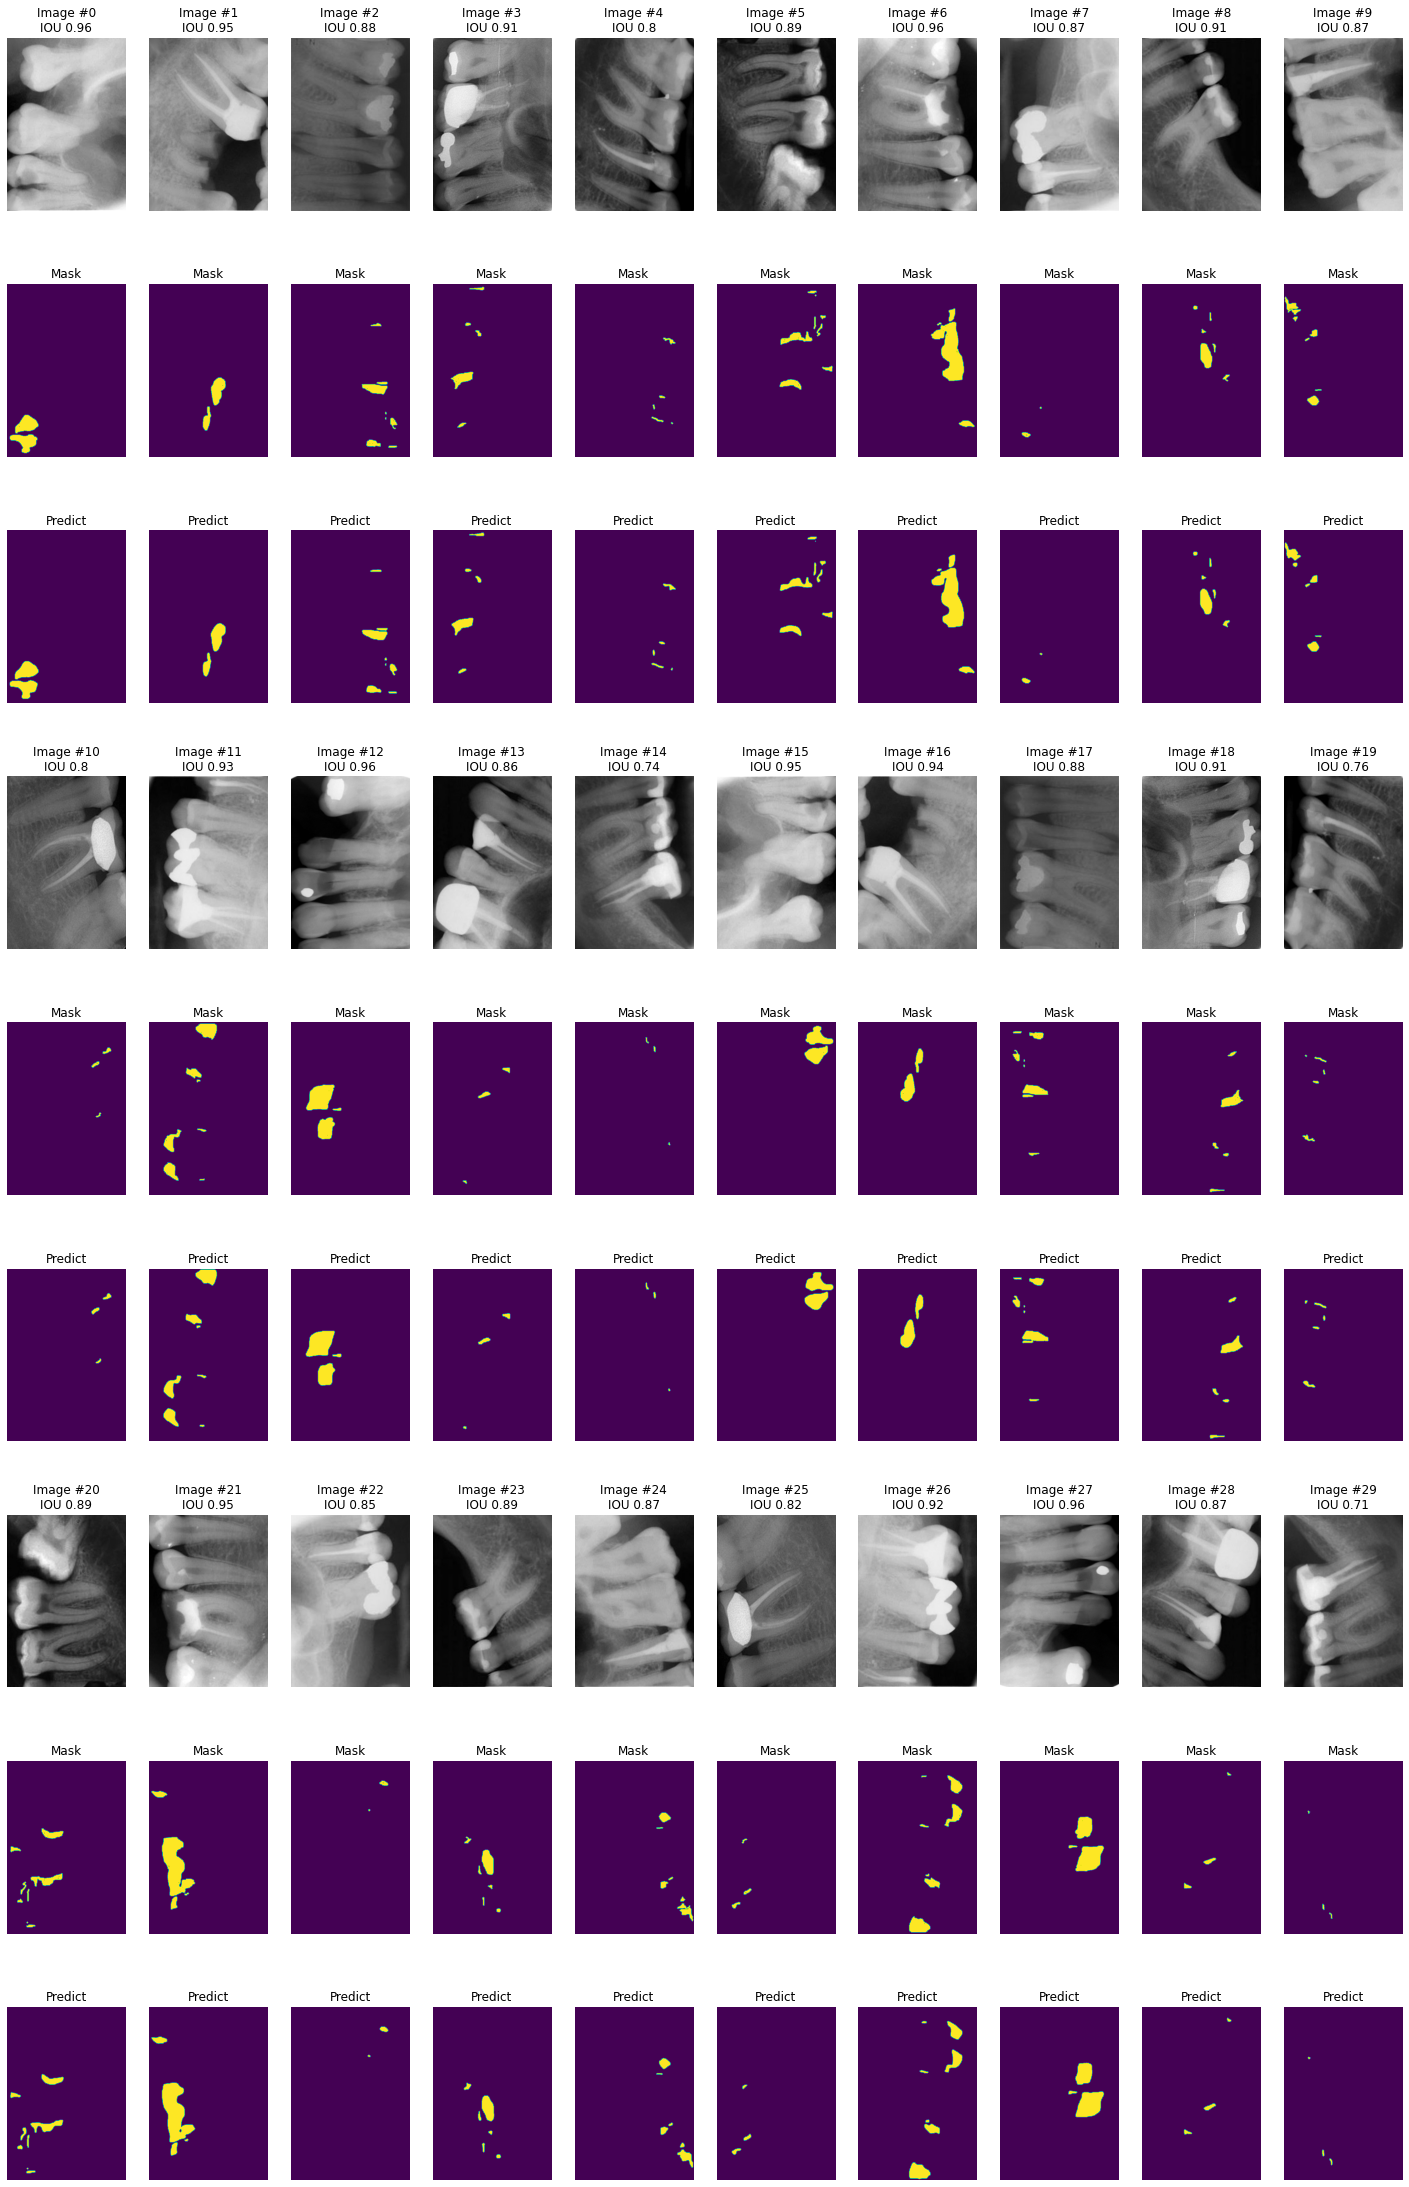

In [ ]:
#plt.figure(figsize=(20,10.5))
plt.figure(figsize=(25,40))
x, y = 10, 3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_test_org[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(y_test_org[pos]), np.squeeze(y_pred_org[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(y_test_org[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(y_pred_org[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

### Calculate the average Dice score on original images with shape 748x512

In [ ]:
def dice_score(A, B):
    intersection = np.logical_and(A, B)
    mask_sum = np.sum(A) + np.sum(B)
    #dice1 = np.sum(2 * intersection)
    dice = np.sum(2 * (intersection)/(mask_sum))
    return dice

dice= []
for i in range(len(y_test_org)):
    dice.append(dice_score(np.squeeze(y_test_org[i]), np.squeeze(y_pred_org[i])))
print('Average Dice score: {}'.format(round(np.mean(dice),2)))

Average Dice score: 0.94


### Plot the individual Dice score with images and masks

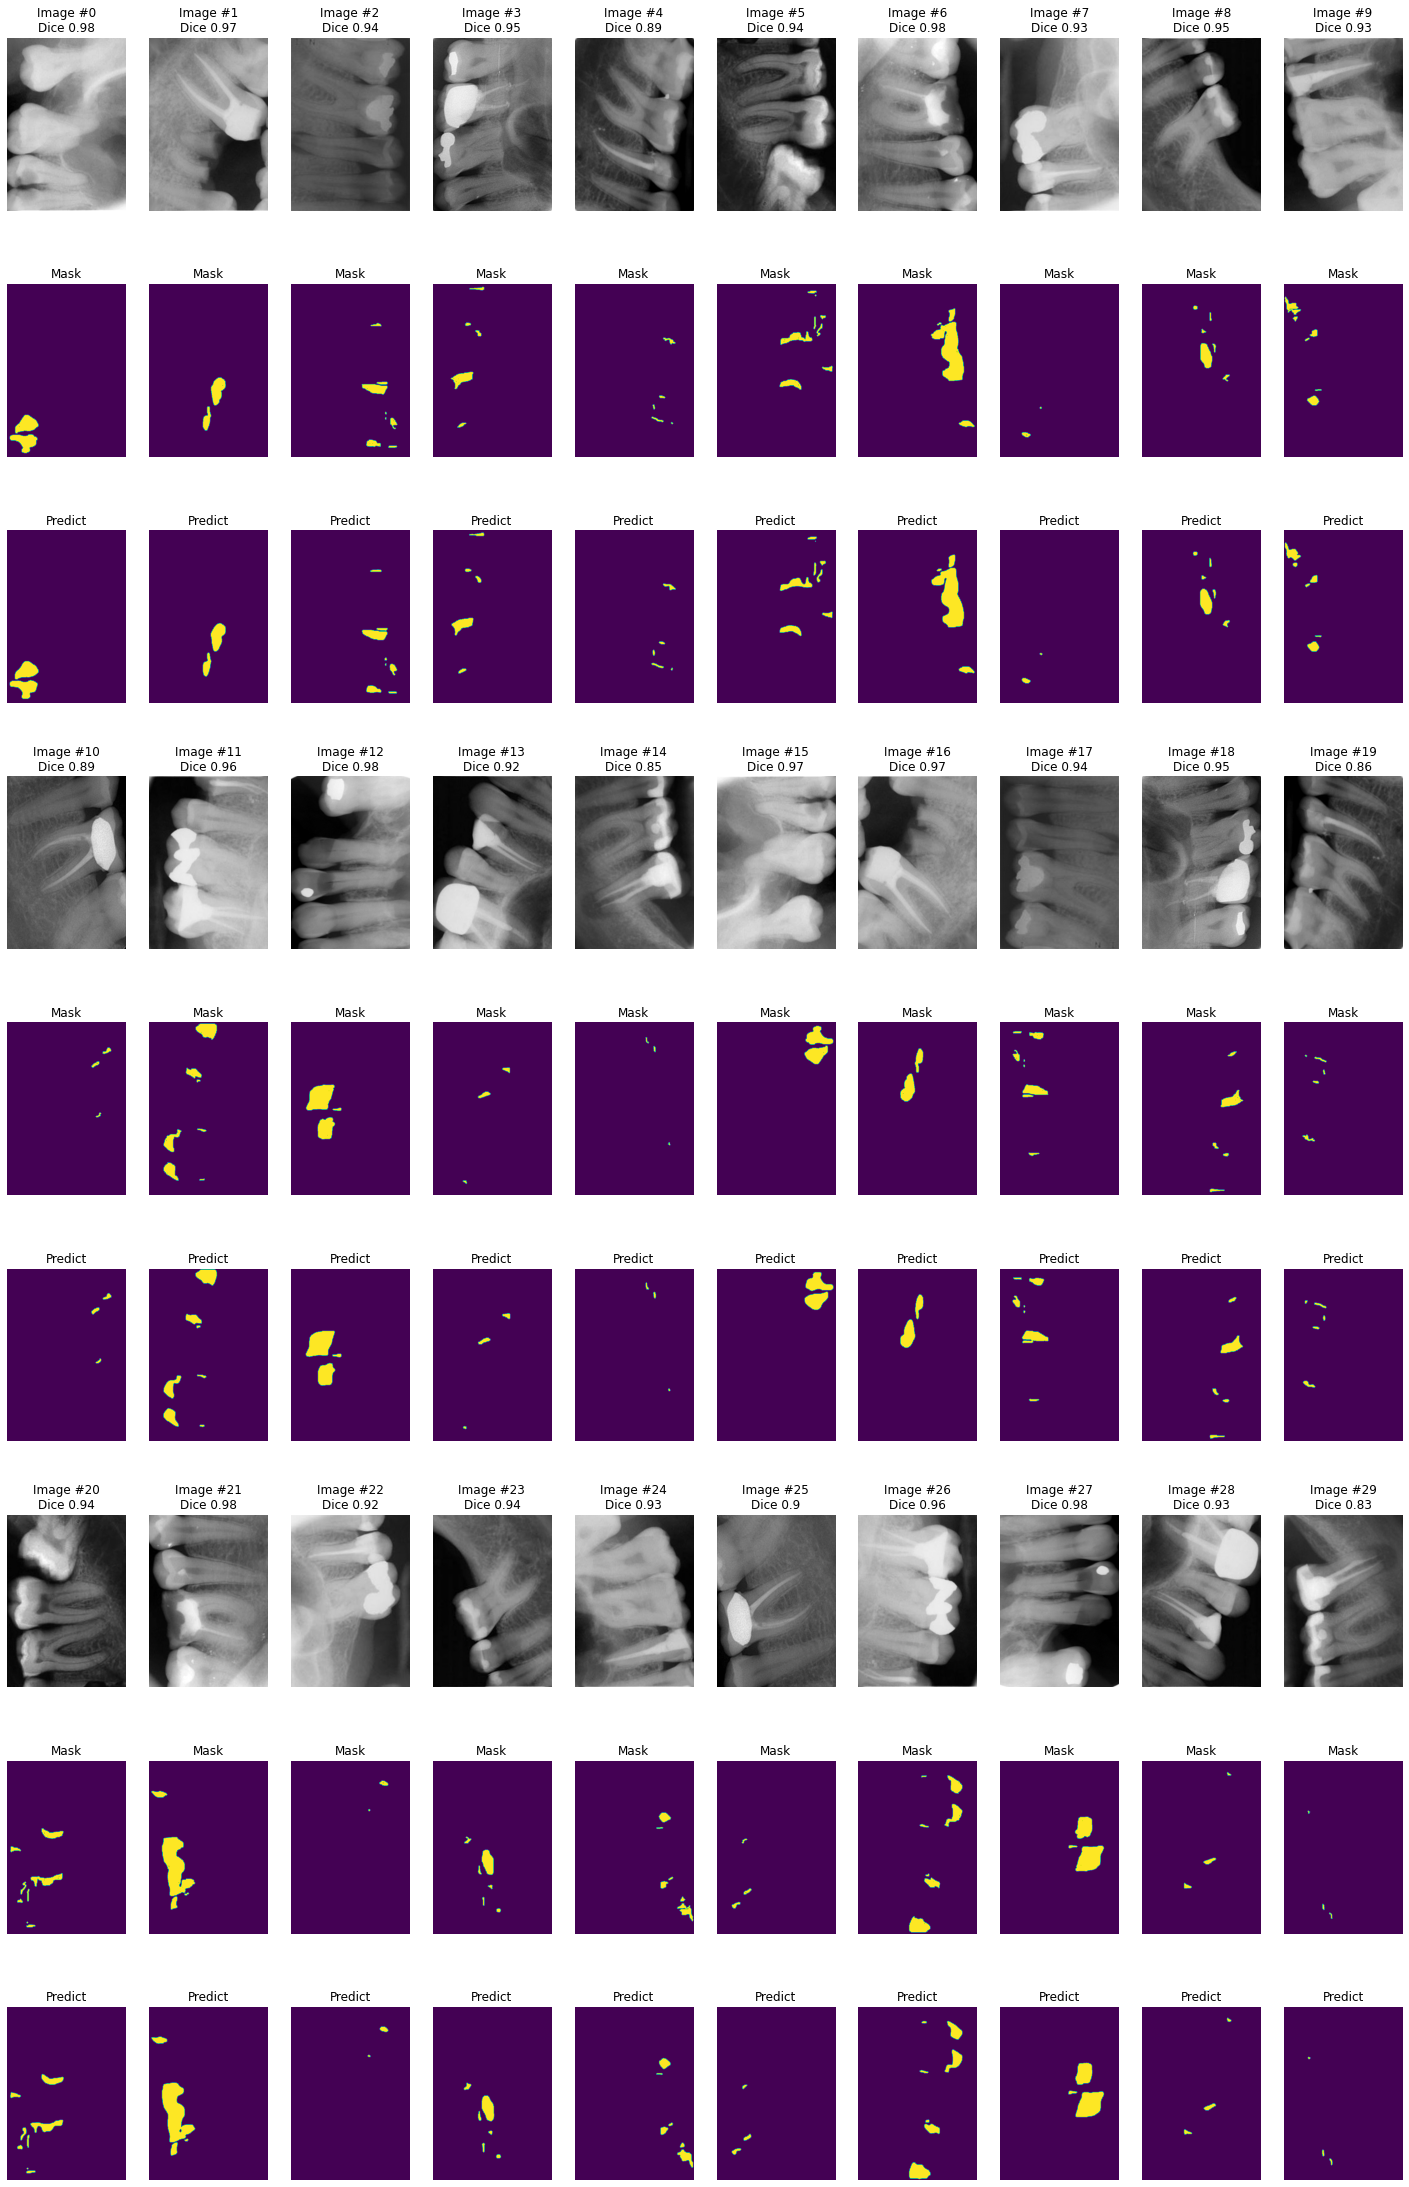

In [ ]:
#plt.figure(figsize=(20,10.5))
plt.figure(figsize=(25,40))
x, y = 10,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_test_org[pos])
        plt.title('Image #{}\nDice {}'.format(pos,round(dice_score(np.squeeze(y_test_org[pos]), np.squeeze(y_pred_org[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(y_test_org[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(y_pred_org[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()